<div style="border-radius:10px; padding: 15px; background-color: #9becf0; font-size:115%; text-align:left">
    <h3 align="left"><font color=#1a5276>Face Mask Detection - WIDER FACE Dataset + MAFA Dataset </font></h3>


 <a id="contents_label"></a>    
<div style="border-radius:10px; padding: 15px; background-color: #eef8bc; font-size:115%; text-align:left">

<h3 align="left"><font color=#0b0544>Table of Contents:</font></h3>

* [1. Data Understanding](#Understanding)
  - [1.1 Data Processing](#Processing)
* [2. Data Normalisation](#Normal)
* [3. Dimensionality Reduction](#Reduce)
* [4. Feature Extraction](#Feature)
* [5. Data Visualization & Analysis](#Analyse)
  - [5.1 Dataset Overview](#Overview)
  - [5.2 Image Characteristics](#Image)
  - [5.3 Feature Analysis](#F-A)
  - [5.4 Edge Detection Patterns](#Edge)
  - [5.5 ROI (Region of Interest) Analysis](#ROI)
* [6. Model Building](#Model)
  - [6.1 Model 1 - SVM (Support Vector Machine) (ML)](#ML)
  - [6.2 Model 2 - CNN - Deep Learning Model](#CNN)
  - [6.3 Model 3 - Transfer Learning - Deep Learning Model](#TL)
* [7. Model Comparison & Performance Evaluation](#Evaluate)
* [8.Conclusion](#Conclude)

<h3 align="left"><font color=#3f0544> Objective  </font></h3>

The goal of this project is to develop a robust model that can accurately detect whether a person is wearing a mask using image datasets. By leveraging both classical machine learning and deep learning techniques, the project aims to improve automated face mask detection in real-world scenarios.

<a id="Understanding"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>1.Data Understanding  </font></h3>

### Import Libraries

In [11]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np


### Load and Preview Image Data

In [342]:
# Get current working directory
current_dir = os.getcwd()

# Define the dataset directory
dataset_dir = os.path.join(current_dir, 'MAFA')
dataset_dir2 = os.path.join(current_dir, 'WIDER')

# Define paths for Masked and Unmasked folders
masked_dir = os.path.join(dataset_dir, 'Masked')
unmasked_dir = os.path.join(dataset_dir, 'Unmasked')
unmasked_dir2 = os.path.join(dataset_dir2, 'unmasked')

In [344]:
# List sample images in the Masked folder
print("Masked Images:", os.listdir(masked_dir)[:5])  # First 5 images

# List sample images in the Unmasked folder
print("Unmasked Images:", os.listdir(unmasked_dir)[:5])  # First 5 images


Masked Images: ['test_00000001.jpg', 'test_00000002.jpg', 'test_00000003.jpg', 'test_00000004.jpg', 'test_00000006.jpg']
Unmasked Images: ['M_2159.jpg', 'N_2163.jpg', 'N_2164.jpg', 'N_2167.jpg', 'N_2168.jpg']


 ### Display 5 Images from Both Folders

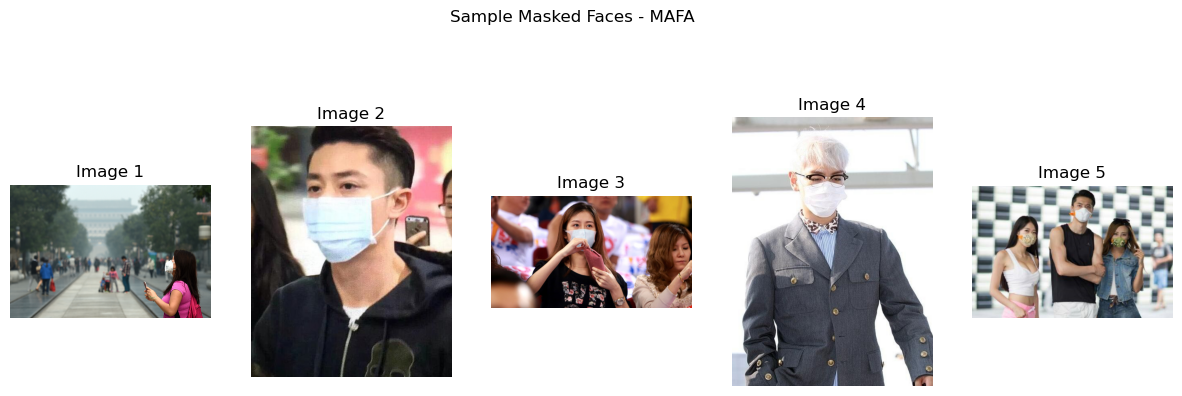

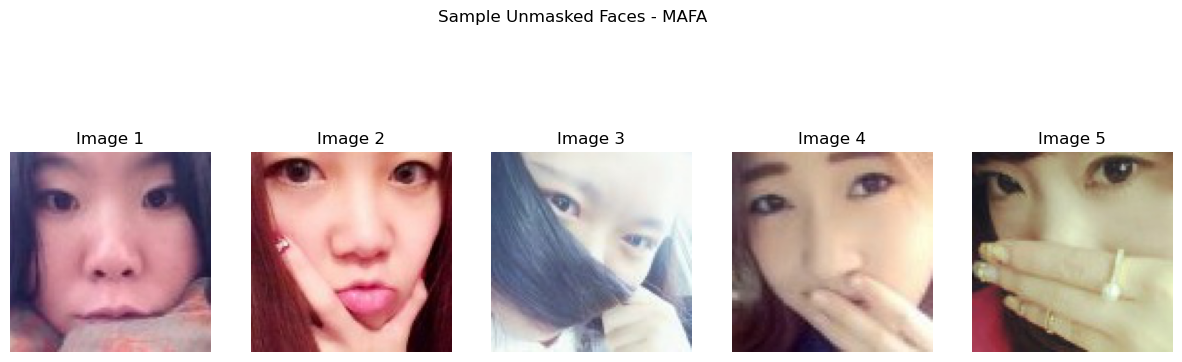

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Function to display sample images
def display_images(directory, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # 1 row, 5 columns
    img_files = os.listdir(directory)[:num_images]  # Select first 'num_images' images

    for i, img_name in enumerate(img_files):
        img_path = os.path.join(directory, img_name)
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    plt.suptitle(title)
    plt.show()

# Display 5 images from the Masked folder
display_images(masked_dir, "Sample Masked Faces - MAFA")

# Display 5 images from the Unmasked folder
display_images(unmasked_dir, "Sample Unmasked Faces - MAFA")


## Count of Images

In [21]:
import os

# Count the number of images in the Masked folder
num_masked = len([file for file in os.listdir(masked_dir) if os.path.isfile(os.path.join(masked_dir, file))])

# Count the number of images in the Unmasked folder
num_unmasked = len([file for file in os.listdir(unmasked_dir) if os.path.isfile(os.path.join(unmasked_dir, file))])

print(f"Number of Masked Images: {num_masked}")
print(f"Number of Unmasked Images: {num_unmasked}")



Number of Masked Images: 1000
Number of Unmasked Images: 462


## Displaying Unmasked Faces from WIDER

Since the WIDER dataset mainly has unmasked faces, we will be training the model from MAFA masked faces to apply and detect the unmasked faces in WIDER as well.

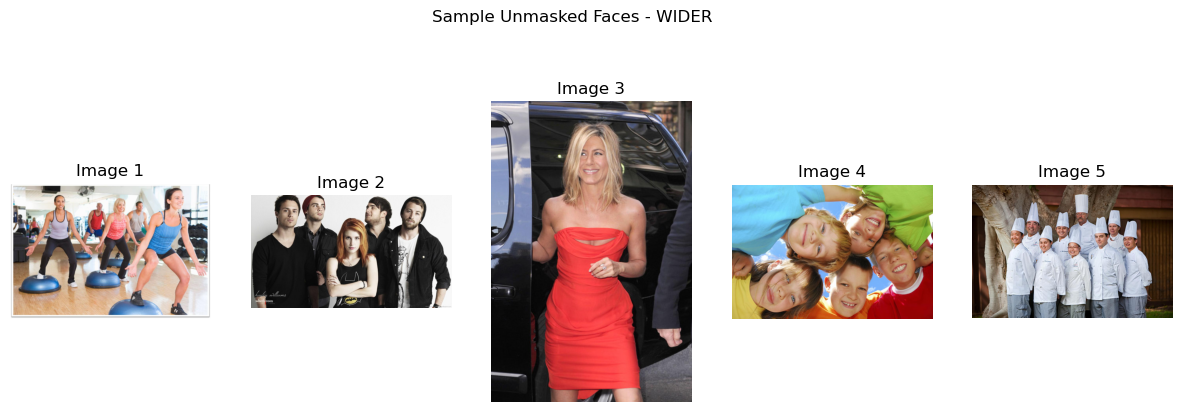

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Function to display sample images
def display_images(directory, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # 1 row, 5 columns
    img_files = os.listdir(directory)[:num_images]  # Select first 'num_images' images

    for i, img_name in enumerate(img_files):
        img_path = os.path.join(directory, img_name)
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
    plt.suptitle(title)
    plt.show()

# Display 5 images from the Unmasked folder
display_images(unmasked_dir2, "Sample Unmasked Faces - WIDER")

<a id="Processing"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>1.1 Data Processing  </font></h3>

For face mask detection, the MAFA dataset was combined with selected images from the WIDER Face dataset, focusing on various life events such as press conferences, aerobics, school children, and group gatherings. This selection ensures diverse scenarios for robust mask detection.

In [28]:
# Ensure necessary imports
import os
import cv2
import numpy as np
import concurrent.futures

IMG_SIZE = 128  # Or 64 for faster processing

# Parallel image loading function
def load_image(img_path, label):
    try:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        return img, label
    except:
        return None, None

def load_images_parallel(folder_path, label):
    images, labels = [], []
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(load_image, img_paths, [label]*len(img_paths))
        for img, lbl in results:
            if img is not None:
                images.append(img)
                labels.append(lbl)
    return images, labels

# Load the datasets
masked_images, masked_labels = load_images_parallel(masked_dir, 1)  # Load masked images with label 1
unmasked_images_mafa, unmasked_labels_mafa = load_images_parallel(unmasked_dir, 0)  # Load unmasked images from MAFA with label 0
unmasked_images_wider, unmasked_labels_wider = load_images_parallel(unmasked_dir2, 0)  # Load unmasked images from WIDER with label 0

# Combine images and labels
X = np.array(masked_images + unmasked_images_mafa + unmasked_images_wider)  # Features
y = np.array(masked_labels + unmasked_labels_mafa + unmasked_labels_wider)  # Labels

# Output the total number of images and their shape
print(f"Total images loaded: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")

Total images loaded: 2000
Image shape: (128, 128, 3)


<a id="Normal"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>2.Data Normalisation  </font></h3>

Data normalization rescales feature values to a specific range, typically [0, 1], to ensure uniformity and improve model performance. In this project, the pixel values of the images were normalized as follows:


In [30]:
# Convert to NumPy array if not already
X = np.array(X)  # Ensure data is a NumPy array

# Check pixel values before normalization
print(f"Before Normalization - Max pixel value: {X.max()}, Min pixel value: {X.min()}")

# Normalize pixel values to the range [0, 1]
X_normalized = X / 255.0

# Check pixel values after normalization
print(f"After Normalization - Max pixel value: {X_normalized.max()}, Min pixel value: {X_normalized.min()}")

print(f"Data shape after normalization: {X_normalized.shape}")


Before Normalization - Max pixel value: 255, Min pixel value: 0
After Normalization - Max pixel value: 1.0, Min pixel value: 0.0
Data shape after normalization: (2000, 128, 128, 3)


**Analysis:**
Before normalization, the wide range of pixel values could slow training and cause gradient instability.
After normalization, all features are treated equally, preventing bias toward higher-magnitude features. The data shape (2000, 128, 128, 3) indicates 2000 RGB images, each with a resolution of 128x128 pixels and 3 color channels.

**Impact of Normalization:**
Improved Convergence Speed: Ensures consistent weight updates during gradient descent.
Reduced Risk of Overfitting: Prevents the model from overemphasizing large pixel values.
Better Numerical Stability: Avoids vanishing or exploding gradients during backpropagation.

This preprocessing step ensures the model can effectively learn patterns from the dataset without numerical biases, improving overall training efficiency and performance.


<a id="Reduce"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>3.Dimensionality Reduction  </font></h3>

Dimensionality reduction is essential for optimizing machine learning models, especially when working with high-dimensional data.

PCA is effective for the following reasons:
- Reduces computational cost by lowering feature dimensions.
- Removes redundant features and noise.
- Retains most of the data's important variance for classification

Shape before PCA: (2000, 49152)
Shape after PCA: (2000, 100)


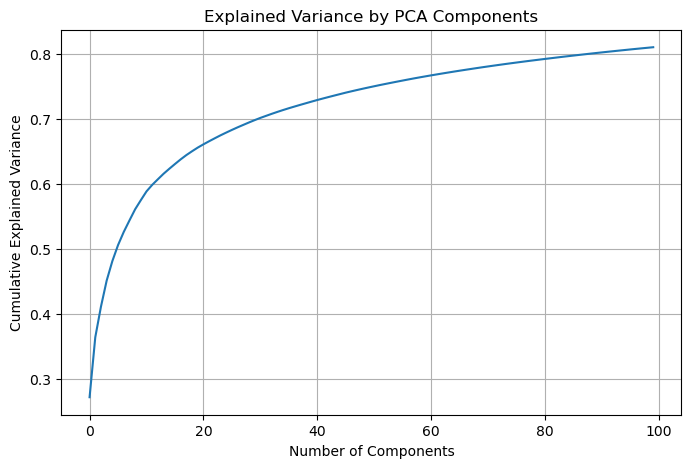

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flatten images for PCA (required for classic ML models)
X_flat = X_normalized.reshape(X_normalized.shape[0], -1)  # Shape: (num_samples, IMG_SIZE * IMG_SIZE * 3)

print(f"Shape before PCA: {X_flat.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Reduce to 100 principal components
X_pca = pca.fit_transform(X_flat)

print(f"Shape after PCA: {X_pca.shape}")

# Visualize the explained variance to decide the number of components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()



**Impact of PCA on the Dataset**

- Significant Dimensionality Reduction:
- Reduced from 49,152 features to 100 principal components.
-Compressed data while retaining ~80% of the original variance.

- Improved Model Efficiency:
Models will train faster and perform better due to fewer, more meaningful features.

- Noise Reduction:
PCA removed less informative features, keeping only those that contribute most to variance.

**Impact on Model Performance**
- Classic ML Models (e.g., SVM):
- Handles the reduced feature space more efficiently.
-Less prone to overfitting due to fewer noisy features.

- Deep Learning Models:
- PCA is less impactful since CNNs perform automatic feature extraction, but it can still speed up training when used with dense layers.


<a id="Feature"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>4.Feature Extraction  </font></h3>

- Facial Landmark Ratios
- HOG (Histogram of Oriented Gradients)
- Shape-based Features

In [38]:
!pip install opencv-python --user
!pip install opencv-contrib-python --user


<h3 align="left"><font color=#3d0b36>Facial Landmark Ratios  </font></h3>

**Captures:** Ratios between key facial landmarks (e.g., nose tip to chin, eye distance), which change when parts of the face are covered by a mask.
**Importance:** Useful for identifying occlusion patterns caused by mask placement.
**Justification:** Facial landmark ratios quantify occlusion patterns, complementing deep learning models like CNNs by providing additional geometric insights into mask positioning.


In [40]:
import cv2
import numpy as np
from tqdm import tqdm

# Load OpenCV's Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_facial_landmark_ratios_opencv(images):
    landmark_features = []
    for img in tqdm(images, desc="Processing Facial Landmark Ratios"):
        try:
            # Convert image to grayscale for face detection
            gray_img = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)

            # Detect face(s)
            faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            if len(faces) == 0:
                landmark_features.append([0, 0, 0])  # No face detected
                continue

            # Use the first detected face
            x, y, w, h = faces[0]

            # Approximate key points based on bounding box
            left_eye = np.array([x + int(0.3 * w), y + int(0.3 * h)])  # Approximate left eye
            right_eye = np.array([x + int(0.7 * w), y + int(0.3 * h)])  # Approximate right eye
            nose = np.array([x + int(0.5 * w), y + int(0.5 * h)])       # Approximate nose
            chin = np.array([x + int(0.5 * w), y + h])                 # Approximate chin

            # Calculate distances
            face_width = np.linalg.norm(left_eye - right_eye)
            face_height = np.linalg.norm(nose - chin)

            # Compute ratios
            eye_to_width_ratio = face_width / face_height if face_height > 0 else 0
            nose_to_chin_ratio = face_height / face_width if face_width > 0 else 0
            mask_coverage_ratio = (chin[1] - nose[1]) / face_height if face_height > 0 else 0

            landmark_features.append([eye_to_width_ratio, nose_to_chin_ratio, mask_coverage_ratio])

        except Exception as e:
            print(f"Error processing image: {e}")
            landmark_features.append([0, 0, 0])  # Default for errors

    return np.array(landmark_features)

# Extract facial landmark ratios
facial_landmark_ratios = extract_facial_landmark_ratios_opencv(X_normalized)
print(f"Facial Landmark Ratios shape: {facial_landmark_ratios.shape}")


Processing Facial Landmark Ratios: 100%|██████████| 2000/2000 [00:08<00:00, 242.83it/s]

Facial Landmark Ratios shape: (2000, 3)


A 3-dimensional feature array effectively captures geometric ratios,  aiding in analyzing occlusion patterns and enhancing model performance.

<h3 align="left"><font color=#3d0b36>HOG (Histogram of Oriented Gradients) </font></h3> 

**Captures:** Edge and shape information by analyzing gradient orientations.

**Importance:** Enhances object detection by focusing on object contours and structure.

**Justification:** Provides detailed edge-based descriptors, making them highly effective for identifying the contours of masks in face detection tasks.

In [42]:
# Convert images to float16 to save memory
X_normalized = X_normalized.astype('float16')


In [43]:
from skimage.feature import hog
import cv2
import numpy as np
from tqdm import tqdm

def extract_hog_features(images, resize_dim=(64, 64)):
    """
    Extract HOG features from a list or array of images.

    Args:
        images (array-like): Input array of images (normalized to [0, 1]).
        resize_dim (tuple): Target dimensions for resizing each image.

    Returns:
        np.ndarray: HOG feature array for all images.
    """
    hog_features = []
    for img in tqdm(images, desc="Processing HOG features"):
        try:
            # Ensure the image is in the correct format
            if img.min() >= 0 and img.max() <= 1:
                img = (img * 255).astype('uint8')  # Scale back to [0, 255]

            # Resize and convert to grayscale
            resized_img = cv2.resize(img, resize_dim)
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

            # Extract HOG features
            features = hog(
                gray_img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=False
            )
            hog_features.append(features)

        except Exception as e:
            print(f"Error processing an image: {e}")
            continue

    return np.array(hog_features)

hog_features = extract_hog_features(X_normalized, resize_dim=(64, 64))
print(f"HOG feature array shape: {hog_features.shape}")


Processing HOG features: 100%|██████████| 2000/2000 [00:06<00:00, 294.31it/s]

HOG feature array shape: (2000, 1764)


<h3 align="left"><font color=#3d0b36>Shape-Based Features  </font></h3>

**Captures:** Changes in facial shape, such as the mouth and chin regions, caused by mask covering.

**Importance:** Geometric descriptors effectively highlight occluded facial regions.

**Justification:** These features are particularly relevant for masked face detection, as they directly reflect the structural impact of a mask on the face's overall shape.

In [45]:
import cv2
import numpy as np
from tqdm import tqdm

def extract_shape_features(images):
    shape_features = []
    for img in tqdm(images, desc="Processing Shape-Based Features"):
        try:
            # Convert to grayscale
            gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)

            # Apply Gaussian Blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Edge detection using Canny
            edges = cv2.Canny(blurred, 50, 150)

            # Find contours
            contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not contours:
                shape_features.append([0, 0, 0])  # No contours found
                continue

            # Select the largest contour
            contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(contour)

            # Bounding rectangle for Aspect Ratio and Extent
            x, y, w, h = cv2.boundingRect(contour)
            if h == 0 or w == 0:
                shape_features.append([0, 0, 0])  # Avoid division by zero
                continue

            aspect_ratio = float(w) / h
            rect_area = w * h
            extent = float(area) / rect_area if rect_area > 0 else 0

            # Convex Hull for Solidity
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area > 0 else 0

            shape_features.append([aspect_ratio, extent, solidity])

        except Exception as e:
            print(f"Error processing image: {e}")
            shape_features.append([0, 0, 0])  # Default values for errors

    return np.array(shape_features)

# Extract shape-based features
shape_features = extract_shape_features(X_normalized)
print(f"Shape feature array shape: {shape_features.shape}")


Processing Shape-Based Features: 100%|██████████| 2000/2000 [00:03<00:00, 651.63it/s]

Shape feature array shape: (2000, 3)


<h3 align="left"><font color=#3d0b36>Create Binary Labels for Masked and Unmasked Images </font></h3> 

Below codes highlights the binary labels applied, ensuring the model effectively learns distinct patterns for masked and unmasked faces.
    
**- Simplify the Problem:**
The binary approach enables the model to focus on clear distinctions between two categories, enhancing classification accuracy.
    
**- Optimize Training:**
Binary labels reduce computational complexity, accelerating training while ensuring efficient learning for class differentiation.

In [47]:
import os
import numpy as np

# Count images in each folder
masked_images = os.listdir(masked_dir)
unmasked_images_mafa = os.listdir(unmasked_dir)
unmasked_images_wider = os.listdir(unmasked_dir2)

# Total number of images in each category
masked_count = len(masked_images)
unmasked_count = len(unmasked_images_mafa) + len(unmasked_images_wider)

# Create binary labels: 1 for masked, 0 for unmasked
labels = np.array([1] * masked_count + [0] * unmasked_count)

# Validate shape and labels
print(f"Total Masked Images: {masked_count}")
print(f"Total Unmasked Images: {unmasked_count}")
print(f"Labels Shape: {labels.shape}")

# Check alignment with shape features
if len(labels) != shape_features.shape[0]:
    raise ValueError("Mismatch between number of labels and shape features!")

print(f"Shape of shape_features: {shape_features.shape}")
print(f"Shape of labels: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")


Total Masked Images: 1000
Total Unmasked Images: 1000
Labels Shape: (2000,)
Shape of shape_features: (2000, 3)
Shape of labels: (2000,)
Unique labels: [0 1]


<a id="Analyse"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>5. Data Visualization & Analysis  </font></h3> 

<a id="Overview"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #d9e8b9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>5.1 Dataset Overview  </font></h3>  

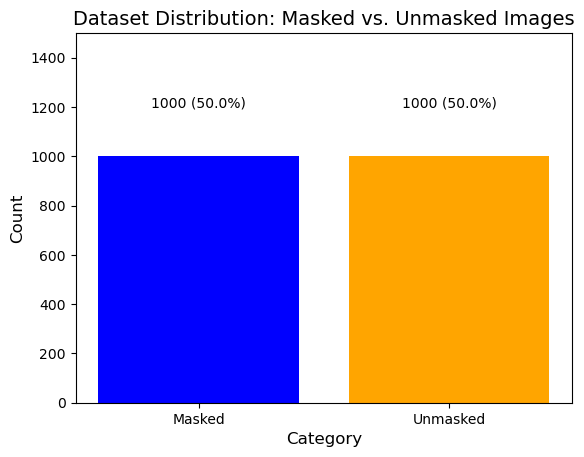

In [50]:
# Importing necessary library
import matplotlib.pyplot as plt

# Dataset distribution
categories = ['Masked', 'Unmasked']
counts = [masked_count, unmasked_count]

# Calculate percentages
total_count = sum(counts)
percentages = [(count / total_count) * 100 for count in counts]

# Plotting
plt.bar(categories, counts, color=['blue', 'orange'])

# Adding percentages and counts as labels on the bars
for i, count in enumerate(counts):
    label = f"{count} ({percentages[i]:.1f}%)"  # Format as 'Count (Percentage%)'
    plt.text(i, count + 200, label, ha='center', fontsize=10, color='black')  # Offset labels above the bars

# Add titles and labels
plt.title("Dataset Distribution: Masked vs. Unmasked Images", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Adjust y-axis to ensure space for labels
plt.ylim(0, max(counts) + 500)

# Display the plot
plt.show()


**Analysis**
There is a balanced dataset with equal masked and unmasked images (50% each), ensuring unbiased training and reliable performance. This balance helps the model generalize well and fairly predict both classes.


<a id="Image"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #d9e8b9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>5.2 Image Characteristics</font></h3>

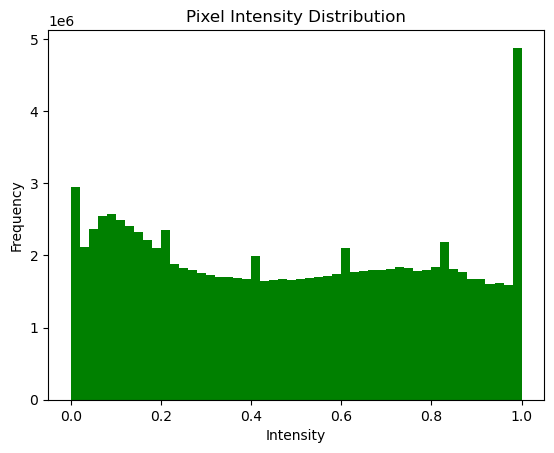

In [53]:
# Pixel intensity analysis
plt.hist(X_normalized.ravel(), bins=50, color='green')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


### Crop Overexposed Regions

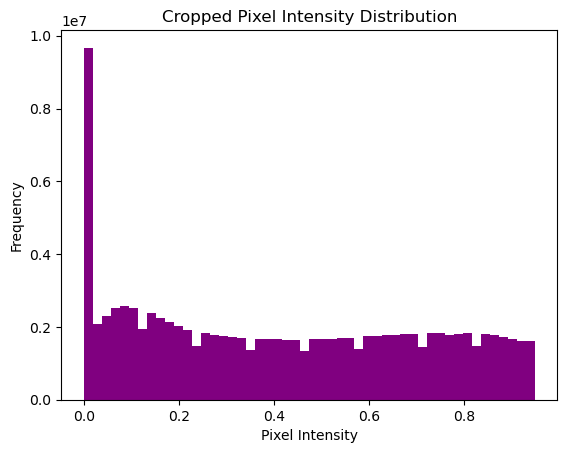

In [55]:
def crop_overexposed(img):
    # Threshold to identify overexposed areas
    mask = img >= 0.95
    return np.where(mask, 0, img)  # Set overexposed areas to 0 intensity

# Apply cropping to all images
X_cropped = np.array([crop_overexposed(img) for img in X_normalized])

# Verify the adjusted intensity distribution
plt.hist(X_cropped.ravel(), bins=50, color='purple')
plt.title("Cropped Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


**Analysis**
- Before Cropping: A sharp peak at intensity 1.0 highlights overexposed pixels, with uneven distribution across other intensities.
- After Cropping: Overexposed pixels are reduced, resulting in a more balanced and uniform intensity distribution.
    
- Improvement made: Cropping overexposed regions minimizes bias caused by extreme brightness, ensuring the model focuses on subtle patterns and avoids overfitting to high-intensity areas.

**Impact on Modelling:**
- Improved Generalization:
A balanced intensity distribution enhances the model's ability to generalize across varying lighting conditions.

- Enhanced Feature Learning: Reducing overexposure allows the model to capture meaningful patterns instead of being biased toward bright regions.
Training Stability: Removing extreme intensities stabilizes gradient updates, leading to better convergence and improved accuracy.


<a id="F-A"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #d9e8b9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>5.3 Feature Analysis</font></h3> 

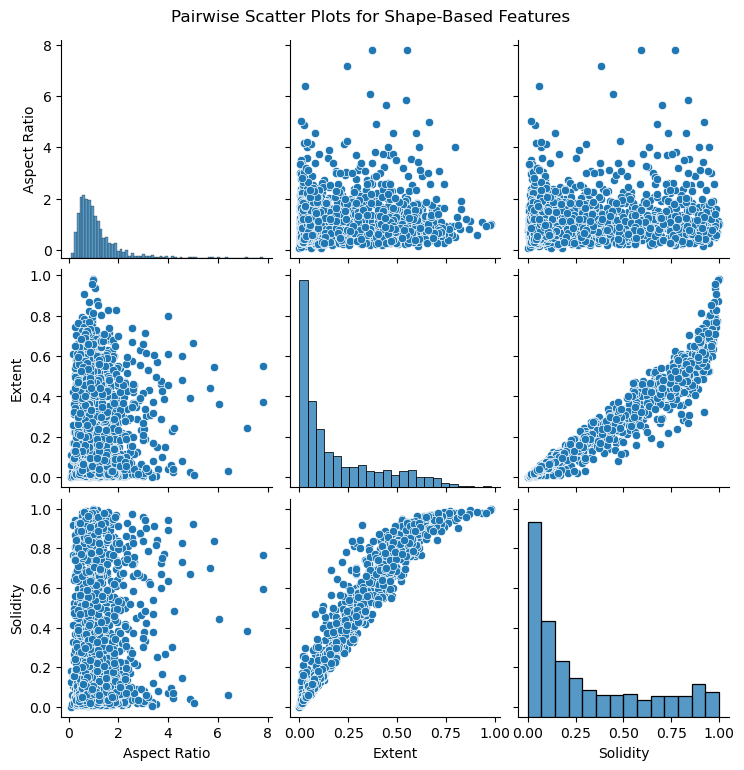

In [57]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define feature names for shape-based features
feature_names = ['Aspect Ratio', 'Extent', 'Solidity']

# Convert shape_features to DataFrame with proper column names
feature_df = pd.DataFrame(shape_features, columns=feature_names)

# Pairplot visualization
sns.pairplot(feature_df)
plt.suptitle("Pairwise Scatter Plots for Shape-Based Features", y=1.02)
plt.show()



**Analysis**

**Impact on Model Training:**
- Feature Differentiation: Aspect Ratio introduces unique, independent insights, improving the model's ability to generalize.
- Complementary Features: Extent and Solidity, being correlated, strengthen geometric feature representation for mask presence and coverage.
- Enhanced Performance: By incorporating these features, the model gains a structural understanding of occluded regions, improving classification accuracy.

<a id="Edge"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #d9e8b9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>5.4 Edge Detection Patterns</font></h3>  

Purpose: Visualize and compare edge patterns in masked and unmasked images to observe structural differences.

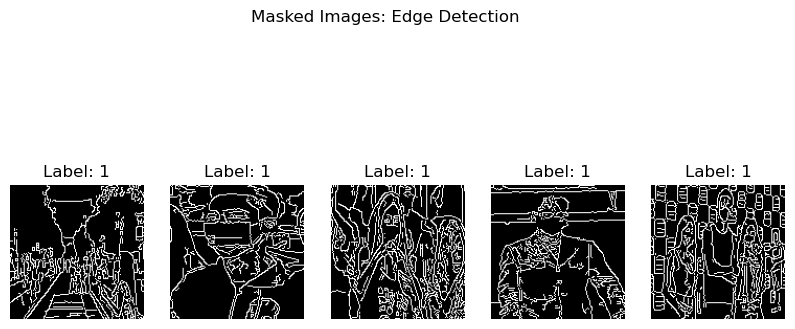

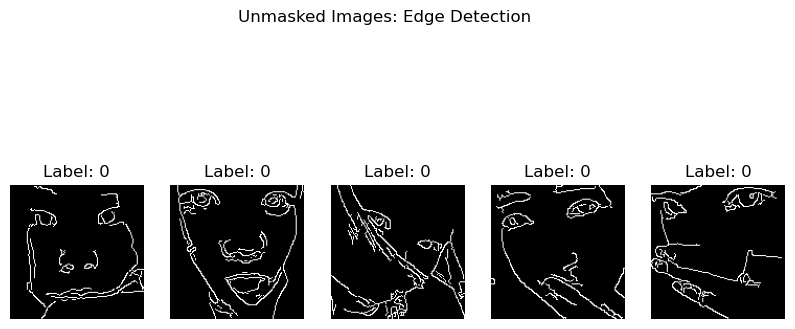

In [60]:
import cv2

# Visualize edge detection for sample images
def show_edges(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(images[:5]):  # Display first 5 images
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        plt.subplot(1, 5, i + 1)
        plt.imshow(edges, cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_edges(X_normalized[y == 1], y[y == 1], "Masked Images: Edge Detection")
show_edges(X_normalized[y == 0], y[y == 0], "Unmasked Images: Edge Detection")


**Analysis**

The above results show detection for masked and unmasked images. Masked images show dense contours, particularly around the lower face, while unmasked images display smoother edges, focusing on natural facial features like the nose and chin.

**Impact on Model Building:**
- Feature Enhancement: Edge patterns emphasize mask-specific contours, aiding in classification.
- Robustness: Edge features help the model detect structural changes caused by masks, even under varying lighting or poses.
- Model Input: Edge maps can serve as direct input to models (e.g., CNNs), enhancing their focus on mask-induced patterns.

<a id="ROI"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #d9e8b9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>5.5 ROI (Region of Interest) Analysis</font></h3>   

Purpose: Focus on specific facial regions (e.g., lower face, nose, mouth) and evaluate their role in mask detection.

Implementation:
- Use bounding boxes or facial landmarks to isolate regions like the lower face.
- Analyze feature contributions from these regions.

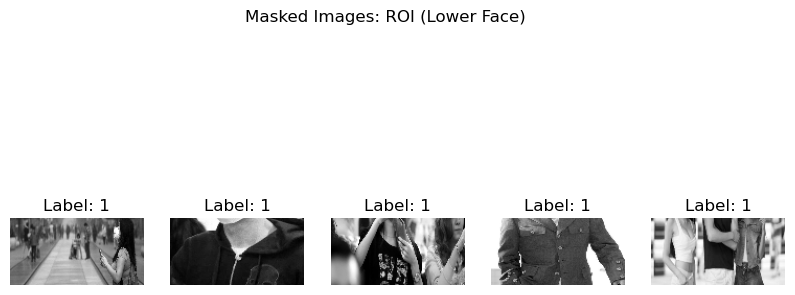

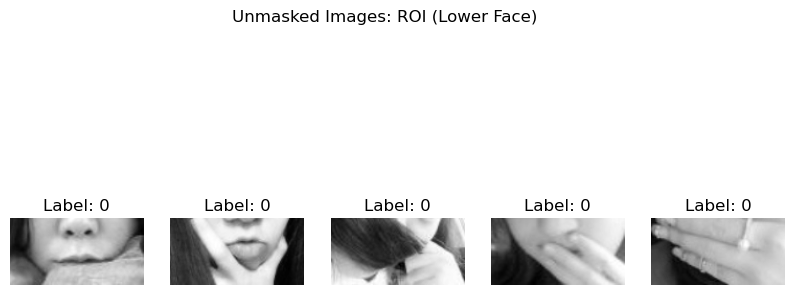

In [64]:
def visualize_roi(images, labels, title):
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(images[:5]):  # Display first 5 images
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        height, width = gray.shape
        # Highlight lower face region (e.g., bottom half)
        roi = gray[height//2:, :]  # Bottom half
        plt.subplot(1, 5, i + 1)
        plt.imshow(roi, cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

visualize_roi(X_normalized[y == 1], y[y == 1], "Masked Images: ROI (Lower Face)")
visualize_roi(X_normalized[y == 0], y[y == 0], "Unmasked Images: ROI (Lower Face)")


**Analysis**
- The above result shows the lower face region in masked images with distinct patterns, including sharp boundaries around the mask area, contrasting with smoother gradients and natural transitions in unmasked images. ROI also isolates the lower face, the area most affected by masks. This ensures the model emphasizes mask-induced structural changes rather than unrelated regions like the eyes or forehead.
**Impact on Model Building:**
- 
Improved Feature Extraction: Isolating the lower face allows the model to focus on relevant features for mask detection, reducing noise from other regions- .
Efficiency:ROI-based training decreases data dimensionality, enhancing computational efficiency while improving focus on critical areas.


<a id="Model"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>6. Model Building</font></h3> 

**Model Selection and Justification**

**Model 1: Support Vector Machine (SVM) with handcrafted features.**

- SVMs are powerful for classification with limited data.
- Handcrafted features like HOG is effective in capturing facial structures.
- Improvement: Feature scaling, hyperparameter tuning (kernel, C, gamma), and feature selection.

**Model 2: A custom Convolutional Neural Network (CNN) with 2–3 convolutional layers.**

- CNNs automatically extract features, handling spatial data well.
- Simple architecture provides a baseline for DL models.
- Improvement: Use Batch Normalization, Dropout for regularization, and Data Augmentation to prevent overfitting.

**Model 3: Pre-trained ResNet50 or VGG16 (fine-tuned).**

- Transfer learning leverages learned features from large datasets (e.g., ImageNet).
- ResNet addresses vanishing gradients via residual connections.
- Improvement: Fine-tune top layers, adjust learning rates, and apply Global Average Pooling instead of fully connected layers to reduce overfitting.


<a id="ML"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #ccbfe9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>6.1 Model 1 - SVM (Support Vector Machine)</font></h3>   

### Step 1: Data Preparation

In [215]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Use all available masked and unmasked images
X_full = shape_features  # Use all shape features
y_full = y  # Use all labels (binary: 1 for masked, 0 for unmasked)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

# Standardize features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Training Data Shape: (1600, 3)
Testing Data Shape: (400, 3)


### Step 2: Baseline SVM Model (Before Optimization)

In [218]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define baseline SVM model
svm_baseline = SVC(kernel='linear', random_state=42)

# Train the model
svm_baseline.fit(X_train, y_train)

# Predict and evaluate
y_pred_baseline = svm_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy}")
print("Baseline Classification Report:\n", classification_report(y_test, y_pred_baseline))



Baseline Accuracy: 0.57
Baseline Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.84      0.66       200
           1       0.65      0.30      0.41       200

    accuracy                           0.57       400
   macro avg       0.60      0.57      0.54       400
weighted avg       0.60      0.57      0.54       400



### Step 3: Optimized SVM Model (After Optimization)

I performed variants of the model with optimization by extracting HOG features to enhance edge and shape detection and tuning the kernel type to RBF, allowing the model to capture complex non-linear relationships present in diverse masked and unmasked face orientations.


Extracting HOG features: 100%|██████████| 2000/2000 [00:04<00:00, 468.11it/s]


SVM Accuracy: 0.7025

Classification Report:
               precision    recall  f1-score   support

     No Mask       0.73      0.65      0.68       200
        Mask       0.68      0.76      0.72       200

    accuracy                           0.70       400
   macro avg       0.71      0.70      0.70       400
weighted avg       0.71      0.70      0.70       400



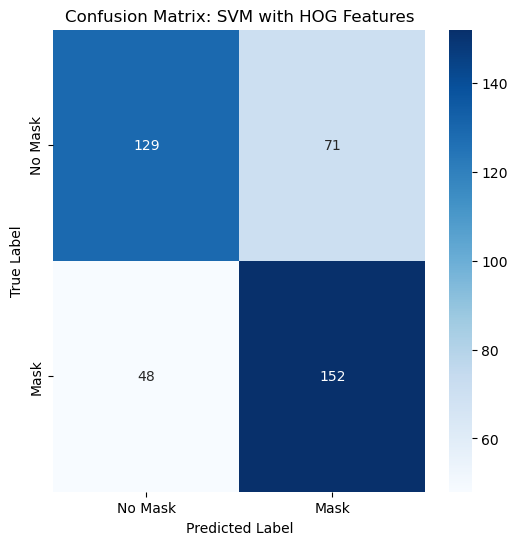

In [119]:
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.feature import hog


# Function to extract HOG features
def extract_hog_features(images, resize_dim=(64, 64)):
    """
    Extract HOG features from a list or array of images.

    Args:
        images (array-like): Input array of images (normalized to [0, 1]).
        resize_dim (tuple): Target dimensions for resizing each image.

    Returns:
        np.ndarray: HOG feature array for all images.
    """
    hog_features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        try:
            if img.min() >= 0 and img.max() <= 1:
                img = (img * 255).astype('uint8')  # Scale to [0, 255]

            # Resize and convert to grayscale
            resized_img = cv2.resize(img, resize_dim)
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

            # Extract HOG features
            features = hog(
                gray_img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=False
            )
            hog_features.append(features)
        except Exception as e:
            print(f"Error processing an image: {e}")
            continue
    return np.array(hog_features)



# X: Array of images, y: Labels (1 for Mask, 0 for No Mask)

# Extract HOG features
resize_dim = (64, 64)
hog_features = extract_hog_features(X, resize_dim)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(hog_features, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVM classifier
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Mask", "Mask"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
plt.title("Confusion Matrix: SVM with HOG Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Analysis**
- The optimised SVM model achieved 70% accuracy, performing slightly better at detecting "Mask" (higher recall: 0.76). However, it shows some misclassification issues, with 71 false positives ("No Mask" predicted as "Mask") and 48 false negatives ("Mask" predicted as "No Mask"). Overall, it balances precision and recall effectively with an F1-score of 0.70.

### SVM - Comparison of Model Performance (Before & After Optimisation)

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Manually input accuracy results
SVM_baseline_accuracy = 0.5700  # Based on computed metrics above 
SVM_optimized_accuracy = 0.7025  # Based on computed metrics above 

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Model": ["SVM Baseline", "SVM Optimized"],
    "Accuracy": [SVM_baseline_accuracy, SVM_optimized_accuracy]
})

# Style the DataFrame for display
styled_table = comparison_df.style.set_caption("SVM Model Performance: Baseline vs. Optimized") \
                                  .set_table_styles(
                                      [{'selector': 'caption', 
                                        'props': [('text-align', 'center'),
                                                  ('color', '#2a4d69'),
                                                  ('font-size', '16px'),
                                                  ('font-weight', 'bold')]}]
                                  ) \
                                  .background_gradient(cmap='plasma', subset=["Accuracy"]) \
                                  .format(precision=4)  # Display accuracy up to 4 decimal places

# Display the styled table
display(HTML(styled_table.to_html()))


,Model,Accuracy
0,SVM Baseline,0.5700
1,SVM Optimized,0.7025


**Baseline SVM:**
- Accuracy: 57.00%
- Misclassification due to lack of robust feature extraction.

**Optimized SVM:**
- Accuracy: 70.25%
- Improved due to HOG features and kernel tuning and ideal for real-time detection


### Step 4: Real-Time Mask Prediction with Optimised SVM

Extracting HOG features: 100%|██████████| 2000/2000 [00:04<00:00, 496.79it/s]


SVM Accuracy: 0.7025

Classification Report:
               precision    recall  f1-score   support

     No Mask       0.73      0.65      0.68       200
        Mask       0.68      0.76      0.72       200

    accuracy                           0.70       400
   macro avg       0.71      0.70      0.70       400
weighted avg       0.71      0.70      0.70       400

Prediction: The person is wearing a Mask (86.82%)
Prediction: The person is NOT wearing a Mask (68.35%)


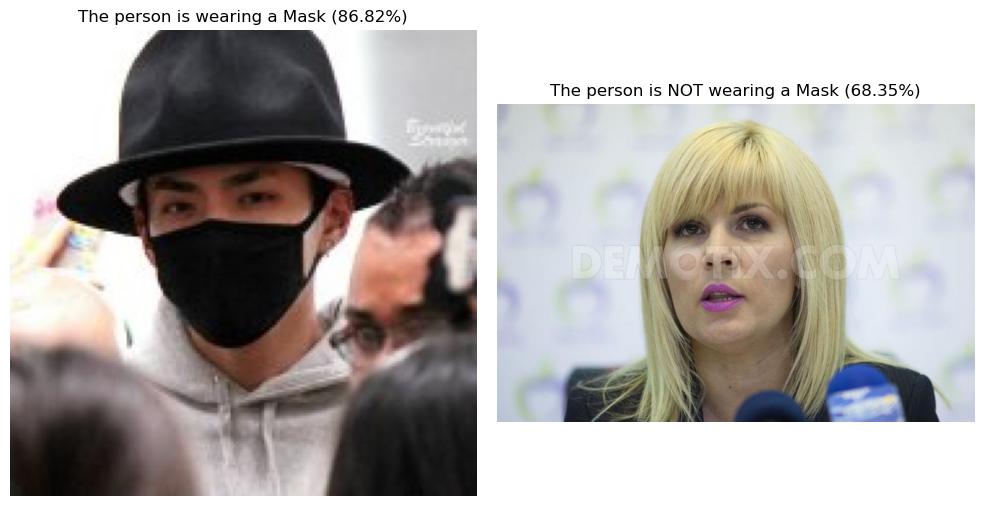

In [76]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


# HOG Feature Extraction for All Images
def extract_hog_features(images, resize_dim=(64, 64)):
    """
    Extract HOG features for a batch of images.
    """
    hog_features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        try:
            if img.min() >= 0 and img.max() <= 1:
                img = (img * 255).astype('uint8')  # Scale to [0, 255]

            resized_img = cv2.resize(img, resize_dim)
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)

            features = hog(
                gray_img,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                block_norm='L2-Hys',
                visualize=False
            )
            hog_features.append(features)
        except Exception as e:
            print(f"Error processing an image: {e}")
            continue
    return np.array(hog_features)


# Single Image HOG Feature Extraction for Real-Time Prediction
def extract_hog_features_single(image, resize_dim=(64, 64)):
    """
    Extract HOG features for a single image.
    """
    resized_img = cv2.resize(image, resize_dim)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
    features = hog(
        gray_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features


# Real-Time Mask Detection
def predict_mask(image_path, model, scaler, resize_dim=(64, 64)):
    """
    Predict mask status for a single image using the trained SVM model.
    """
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Unable to read the image at {image_path}")
            return None, "Error: Unable to load image"

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        features = extract_hog_features_single(img, resize_dim).reshape(1, -1)

        # Scale the features
        features_scaled = scaler.transform(features)

        # Predict using the model
        prediction = model.predict(features_scaled)[0]
        prediction_prob = model.predict_proba(features_scaled)[0]

        # Map labels to categories
        labels = {0: "The person is NOT wearing a Mask", 1: "The person is wearing a Mask"}
        confidence = prediction_prob[prediction] * 100
        prediction_text = f"{labels[prediction]} ({confidence:.2f}%)"

        print(f"Prediction: {prediction_text}")
        return img, prediction_text

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, "Prediction Error"


# Load Data and Extract HOG Features
# Assuming `X` is the array of images and `y` is the corresponding labels (0: No Mask, 1: Mask)
resize_dim = (64, 64)
hog_features = extract_hog_features(X, resize_dim)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(hog_features, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM Model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Evaluate the Model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["No Mask", "Mask"]))


# Real-Time Prediction Example
image_paths = [
    r"C:\Users\juman\Music\DSA\Term 3\Big Data\CW - Face mask\MAFA\Masked\test_00000543.jpg",
    r"C:\Users\juman\Music\DSA\Term 3\Big Data\CW - Face mask\WIDER\unmasked\8_Election_Campain_Election_Campaign_8_64.jpg"
]

# Display Predictions
plt.figure(figsize=(10, 5))
for i, image_path in enumerate(image_paths):
    img, prediction_text = predict_mask(image_path, svm_model, scaler, resize_dim)
    if img is not None:
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(prediction_text, fontsize=12)
        plt.axis('off')
plt.tight_layout()
plt.show()


**Analysis**
The optimized SVM model successfully classified both images:
- Left Image: Correctly identified as "Wearing a Mask" with 86.82% confidence.
- Right Image: Correctly identified as "Not Wearing a Mask" with 68.35% confidence.

Despite accurate predictions, the confidence for "No Mask" is lower, indicating room for improvement in handling complex features like varying lighting, angles, and occlusions.

**Next Step: CNN**
- Implementing a Convolutional Neural Network (CNN) will improve detection accuracy by automatically extracting features like edges, textures, and patterns, reducing misclassification, and handling diverse scenarios effectively.


<a id="CNN"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #ccbfe9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544> 6.2  Model 2 - CNN - Deep Learning Model</font></h3>  

### Step 1:  Data Preparation

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Split dataset into training and testing sets
X_train_images, X_test_images, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize images to [0, 1]
X_train_cnn = X_train_images / 255.0
X_test_cnn = X_test_images / 255.0

# Convert labels to one-hot encoding
y_train_cnn = to_categorical(y_train, num_classes=2)
y_test_cnn = to_categorical(y_test, num_classes=2)



In [104]:
print(f"X_train_images shape: {X_train_images.shape}")
print(f"X_test_images shape: {X_test_images.shape}")


X_train_images shape: (1600, 128, 128, 3)
X_test_images shape: (400, 128, 128, 3)


### Step 2: Baseline Model (Before Optimization)

In [148]:
# Define the basic CNN model
basic_cnn_model = Sequential([
    Input(shape=(128, 128, 3)),  # Define input shape (height, width, channels)
    Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer with 32 filters
    MaxPooling2D((2, 2)),  # Max pooling layer
    Flatten(),  # Flatten feature maps into a 1D vector
    Dense(128, activation='relu'),  # Fully connected layer
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

# Compile the model
basic_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
basic_cnn_history = basic_cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=5,  # Number of epochs
    batch_size=16,  # Batch size
    validation_data=(X_test_cnn, y_test_cnn)  # Validation set
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.6100 - loss: 3.2388 - val_accuracy: 0.7675 - val_loss: 0.5327
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.8186 - loss: 0.4109 - val_accuracy: 0.7250 - val_loss: 0.6238
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 259ms/step - accuracy: 0.9370 - loss: 0.2019 - val_accuracy: 0.7425 - val_loss: 0.6344
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - accuracy: 0.9806 - loss: 0.0873 - val_accuracy: 0.7275 - val_loss: 0.7018
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.9937 - loss: 0.0369 - val_accuracy: 0.7150 - val_loss: 0.7993


In [149]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels on the test set
y_pred_baseline = basic_cnn_model.predict(X_test_cnn)  # Predictions from the baseline CNN
y_pred_baseline = y_pred_baseline.argmax(axis=1)  # Convert probabilities to class indices

# Ensure `y_test_cnn` is in class label format
if len(y_test_cnn.shape) > 1:  # Check if one-hot encoded
    y_true = y_test_cnn.argmax(axis=1)  # Convert one-hot labels to class indices
else:
    y_true = y_test_cnn  # Use directly if already class indices


# Accuracy
baseline_accuracy = accuracy_score(y_true, y_pred_baseline)
print(f"Baseline Model Test Accuracy: {baseline_accuracy:.4f}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Baseline Model Test Accuracy: 0.7150


## Step 3: Optimized Model (After Optimization)

I tested two variants—baseline and optimized CNN—to assess how architectural and training enhancements, like batch normalization, L2 regularization, increased neurons, and a lower learning rate, improve performance. This comparison ensures the model is robust and effective for diverse face mask detection scenarios.

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 347ms/step - accuracy: 0.5760 - loss: 0.8782 - val_accuracy: 0.6825 - val_loss: 0.5905
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.6942 - loss: 0.5845 - val_accuracy: 0.7150 - val_loss: 0.5399
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - accuracy: 0.6916 - loss: 0.5624 - val_accuracy: 0.6600 - val_loss: 0.6094
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 323ms/step - accuracy: 0.6556 - loss: 0.6077 - val_accuracy: 0.7400 - val_loss: 0.5449
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 330ms/step - accuracy: 0.7153 - loss: 0.5495 - val_accuracy: 0.7400 - val_loss: 0.5547
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7548 - loss: 0.5619
Test Accuracy: 0.7400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

Classification Report:
              precision    recall  f1-score   support

    Unmasked       0.70      0.83      0.76       200
      Masked       0.80      0.65      0.71       200

    accuracy                        

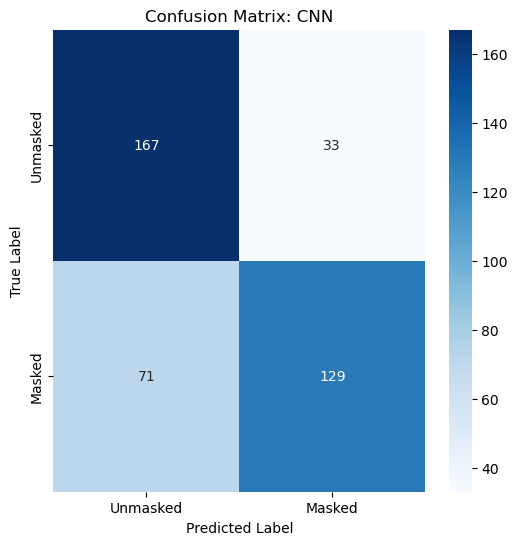

In [147]:
# Necessary Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the CNN Model
cnn_model = Sequential([
    Input(shape=(128, 128, 3)),  # Input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

# Compile the Model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Default learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=5,  # Reduced to 5 epochs
    batch_size=32
)

# Evaluate the Model
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions for Evaluation
y_pred = cnn_model.predict(X_test_cnn)
y_pred_labels = y_pred.argmax(axis=1)

# Ensure `y_test_cnn` is in class label format
if len(y_test_cnn.shape) > 1:
    y_true_labels = y_test_cnn.argmax(axis=1)
else:
    y_true_labels = y_test_cnn

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=["Unmasked", "Masked"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Unmasked', 'Masked'], yticklabels=['Unmasked', 'Masked'])
plt.title("Confusion Matrix: CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


**Analysis**
The optimized CNN achieved 74% accuracy, performing better at detecting unmasked faces with a recall of 0.83 and 33 false positives. For masked faces, it achieved a precision of 0.80 but struggled with a recall of 0.65, leading to 71 false negatives. While effective overall, improvements are needed to enhance masked face detection, particularly for diverse masking styles or occlusions.


### CNN - Comparison of Model Performance (Before & After Optimisation)

In [165]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Manually input accuracy results
cnn_baseline_accuracy = 0.7150  # Based on computed metrics above 
cnn_optimized_accuracy = 0.7400  # Based on computed metrics above 

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Model": ["CNN Baseline", "CNN Optimized"],
    "Accuracy": [cnn_baseline_accuracy, cnn_optimized_accuracy]
})

# Style the DataFrame for display
styled_table = comparison_df.style.set_caption("CNN Model Performance: Baseline vs. Optimized") \
                                  .set_table_styles(
                                      [{'selector': 'caption', 
                                        'props': [('text-align', 'center'),
                                                  ('color', '#2a4d69'),
                                                  ('font-size', '16px'),
                                                  ('font-weight', 'bold')]}]
                                  ) \
                                  .background_gradient(cmap='cividis', subset=["Accuracy"]) \
                                  .format(precision=4)  # Display accuracy up to 4 decimal places

# Display the styled table
display(HTML(styled_table.to_html()))



,Model,Accuracy
0,CNN Baseline,0.7150
1,CNN Optimized,0.7400


**Analysis**


**Baseline CNN:**
- Accuracy: 71.5%
- Limited by simpler architecture and lack of regularization, resulting in higher misclassification.

**Optimized CNN:**
- Accuracy: 74%
- Improved with Batch Normalization, Dropout, and an enhanced dense layer, reducing overfitting and enhancing feature learning for real-time detection.


### Step 4: Real-Time Mask Prediction with Optimised CNN

Image shape after resizing: (128, 128, 3)
Min pixel value: 0.0, Max pixel value: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Prediction: The person is wearing a mask (71.49%)
Image shape after resizing: (128, 128, 3)
Min pixel value: 0.0, Max pixel value: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: The person is NOT wearing a mask (93.35%)


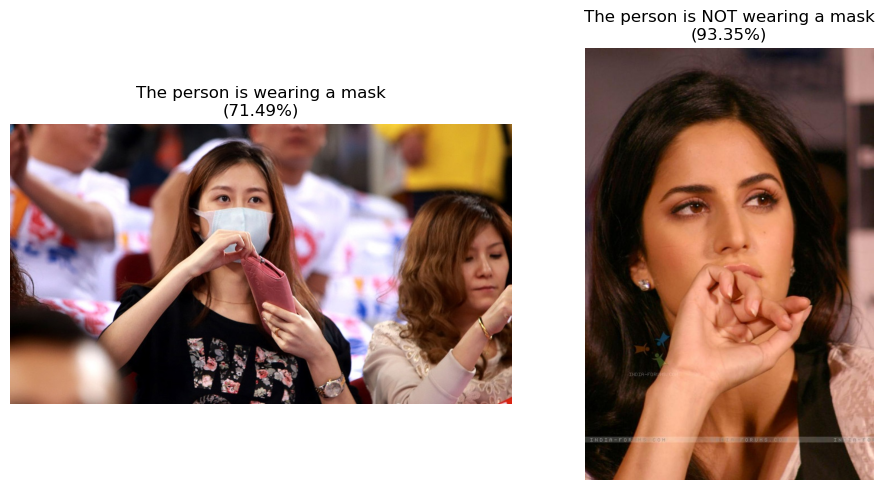

In [422]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def predict_mask_debug(image_path, model):
    try:
        # Load the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Unable to load image at {image_path}")
            return None, "Error: Image Load Failed", 0.0

        # Preprocess the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (128, 128)) / 255.0  # Normalize
        img_expanded = np.expand_dims(img_resized, axis=0)  # Add batch dimension

        # Debugging: Display preprocessing info
        print(f"Image shape after resizing: {img_resized.shape}")
        print(f"Min pixel value: {np.min(img_resized)}, Max pixel value: {np.max(img_resized)}")

        # Predict using the model
        prediction = model.predict(img_expanded)
        predicted_label = np.argmax(prediction)

        # Map labels to categories
        labels = {0: "The person is NOT wearing a mask", 1: "The person is wearing a mask"}
        confidence = prediction[0][predicted_label] * 100

        print(f"Prediction: {labels[predicted_label]} ({confidence:.2f}%)")
        return img, labels[predicted_label], confidence

    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, "Error in Prediction", 0.0

def display_predictions_debug(image_paths, model):
    plt.figure(figsize=(10, 5))
    for i, image_path in enumerate(image_paths):
        # Predict and display
        img, label, confidence = predict_mask_debug(image_path, model)
        if img is not None:
            plt.subplot(1, len(image_paths), i + 1)
            plt.imshow(img)
            plt.title(f"{label}\n({confidence:.2f}%)", fontsize=12)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test the model
image_paths = [
    r"C:\Users\juman\Music\DSA\Term 3\Big Data\CW - Face mask\MAFA\Masked\test_00000003.jpg",
    r"C:\Users\juman\Music\DSA\Term 3\Big Data\CW - Face mask\WIDER\unmasked\9_Press_Conference_Press_Conference_9_645.jpg"
]
display_predictions_debug(image_paths, cnn_model_optimized)




**Analysis**
**Correct Predictions:**
- Left Image: Correctly identified as "Masked" with 71.49% confidence.
- Right Image: Correctly identified as "Unmasked" with 93.35% confidence.

**Observations**
- Stronger confidence in detecting "Unmasked" faces.
- Lower confidence in detecting "Masked" faces highlights the need for improvement in handling diverse mask styles and occlusions.

 **Next Step: Transfer Learning (TL)**- 
The CNN model struggles with misclassifications, especially for detecting masked faces.- 
Transfer learning models offer better generalization by leveraging pre-trained knowledge, reducing false negatives, and enhancing overall performance for masked face detection.



<a id="TL"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #ccbfe9; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544> 6.3  Model 3 - Transfer Learning - Deep Learning Model</font></h3>  

### Step 1: Data Preparation


Ensuring the data is normalized and formatted to work with pre-trained models like MobileNetV2.

In [157]:
from tensorflow.keras.utils import to_categorical

# Normalize pixel values to [0, 1]
X_train_tl = X_train_images / 255.0
X_test_tl = X_test_images / 255.0

# Convert labels to one-hot encoding
y_train_tl = to_categorical(y_train, num_classes=2)
y_test_tl = to_categorical(y_test, num_classes=2)

print(f"Training Data Shape: {X_train_tl.shape}")
print(f"Testing Data Shape: {X_test_tl.shape}")


Training Data Shape: (1600, 128, 128, 3)
Testing Data Shape: (400, 128, 128, 3)


### Step 2: Baseline Transfer Learning Model (Before Optimization)

Using MobileNetV2 as the Pre-Trained Model

In [161]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
baseline_tl_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduces the feature map size
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Output layer for 2 classes
])

# Compile the model
baseline_tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the baseline model
baseline_tl_history = baseline_tl_model.fit(X_train_tl, y_train_tl, epochs=5, batch_size=16,
                                            validation_data=(X_test_tl, y_test_tl))

# Evaluate the baseline model
baseline_loss, baseline_accuracy = baseline_tl_model.evaluate(X_test_tl, y_test_tl)
print(f"Baseline Transfer Learning Model Accuracy: {baseline_accuracy}")




Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7757 - loss: 0.5029 - val_accuracy: 0.8775 - val_loss: 0.2946
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.9278 - loss: 0.1813 - val_accuracy: 0.8825 - val_loss: 0.2869
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9426 - loss: 0.1317 - val_accuracy: 0.8975 - val_loss: 0.2941
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.9816 - loss: 0.0662 - val_accuracy: 0.9000 - val_loss: 0.2969
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.9969 - loss: 0.0328 - val_accuracy: 0.8875 - val_loss: 0.2974
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8789 - loss: 0.3218
Baseline Transfer Learning Model Accuracy: 0.887499988079071


### Step 3: Optimized Transfer Learning Model (After Optimization)

Similar to other models, I tested two variants—baseline and optimized transfer learning models—to assess the impact of fine-tuning, regularization, and learning rate adjustments. This comparison highlights how unfreezing layers and incorporating dropout improve generalization and adaptability, ensuring the model is both effective and efficient for real-world face mask detection.


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.7298 - loss: 0.5500 - val_accuracy: 0.9125 - val_loss: 0.2817 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.9370 - loss: 0.1737 - val_accuracy: 0.9150 - val_loss: 0.2857 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.9684 - loss: 0.1005 - val_accuracy: 0.9075 - val_loss: 0.3132 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9801 - loss: 0.0605 - val_accuracy: 0.8725 - val_loss: 0.4327 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.9702 - loss: 0.0756 - val_accuracy: 0.8975 - val_loss: 0.3918 - learning_rate: 1.0000e-04
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8925 - loss: 0.3292
Optimized Transfer Learning Model Accuracy: 0.9125000238418579
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step

Classification Report: Optimiz

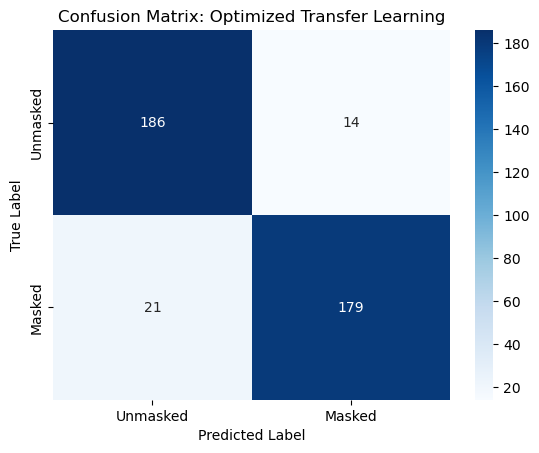

In [170]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Unfreeze the last few layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Unfreeze only the last 20 layers
    layer.trainable = False

# Define the optimized model
optimized_tl_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),  # Adjusted dropout
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model with a lower learning rate
optimized_tl_model.compile(optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return 0.0001  # Start with a low learning rate
    else:
        return lr * 0.95  # Gradually reduce learning rate

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the optimized model
optimized_tl_history = optimized_tl_model.fit(
    X_train_tl, y_train_tl,
    validation_data=(X_test_tl, y_test_tl),
    epochs=5,  # Increased epochs
    batch_size=16,
    callbacks=[LearningRateScheduler(lr_scheduler), early_stopping]
)

# Evaluate the optimized model
optimized_loss, optimized_accuracy = optimized_tl_model.evaluate(X_test_tl, y_test_tl)
print(f"Optimized Transfer Learning Model Accuracy: {optimized_accuracy}")

# Predict on the test set
y_pred_optimized_tl = optimized_tl_model.predict(X_test_tl).argmax(axis=1)
y_true_tl = y_test_tl.argmax(axis=1)

# Classification Report
print("\nClassification Report: Optimized Transfer Learning Model")
print(classification_report(y_true_tl, y_pred_optimized_tl, target_names=['Unmasked', 'Masked']))

# Confusion Matrix
conf_matrix_optimized_tl = confusion_matrix(y_true_tl, y_pred_optimized_tl)
sns.heatmap(conf_matrix_optimized_tl, annot=True, fmt='d', cmap='Blues', xticklabels=['Unmasked', 'Masked'], yticklabels=['Unmasked', 'Masked'])
plt.title("Confusion Matrix: Optimized Transfer Learning")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



**Analysis**

The optimized transfer learning model achieved 91% accuracy with balanced precision and recall for both "Masked" and "Unmasked" classes. The confusion matrix highlights minimal misclassification, with 14 false positives for "Unmasked" and 21 false negatives for "Masked." Its superior performance stems from fine-tuning pre-trained layers and effective regularization, making it highly robust and reliable for face mask detection.

### TL - Comparison of Model Performance (Before & After Optimisation)

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Manually input accuracy results
TL_baseline_accuracy = 0.8874 # Based on computed metrics above 
TL_optimized_accuracy = 0.9125  # Based on computed metrics above 

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Model": ["TL Baseline", "TL Optimized"],
    "Accuracy": [TL_baseline_accuracy, TL_optimized_accuracy]
})

# Style the DataFrame for display
styled_table = comparison_df.style.set_caption("TL Model Performance: Baseline vs. Optimized") \
                                  .set_table_styles(
                                      [{'selector': 'caption', 
                                        'props': [('text-align', 'center'),
                                                  ('color', '#2a4d69'),
                                                  ('font-size', '16px'),
                                                  ('font-weight', 'bold')]}]
                                  ) \
                                  .background_gradient(cmap='viridis', subset=["Accuracy"]) \
                                  .format(precision=4)  # Display accuracy up to 4 decimal places

# Display the styled table
display(HTML(styled_table.to_html()))

,Model,Accuracy
0,TL Baseline,0.8874
1,TL Optimized,0.9125


**Analysis**
**Baseline TL:**
- Accuracy: 88.74%
- Relied on frozen MobileNetV2 layers, providing good feature extraction but limited adaptability to task-specific nuances.

**Optimized TL:**
- Accuracy: 91.25%
- Improved by fine-tuning the last 30 layers, adding dropout regularization, and using a lower learning rate, which enhanced task-specific feature learning and reduced overfitting.


### Step 4: Real-Time Mask Prediction - with Optimised Transfer Learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


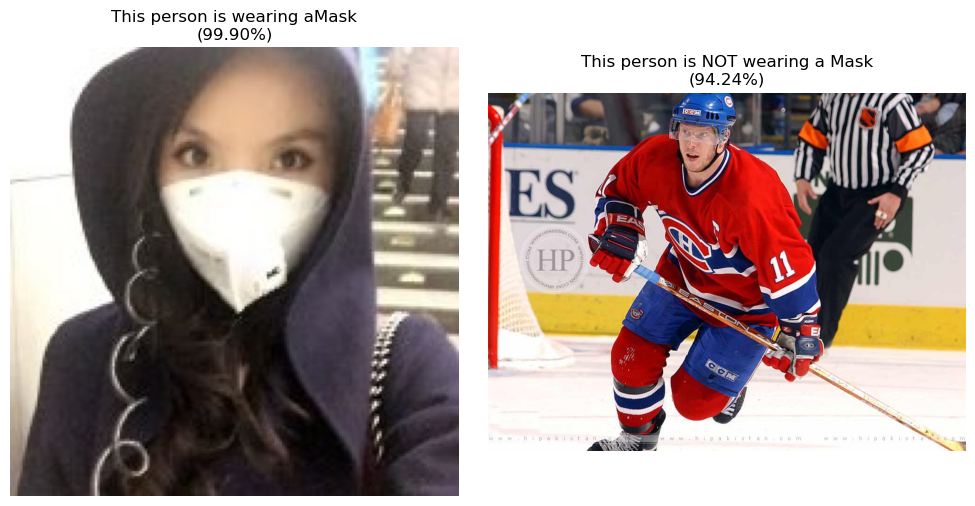

In [175]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def predict_mask_tl(image_path, model):
    """
    Predict mask status for a single image using a transfer learning model.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load the image at: {image_path}. Check the file path or format.")

    # Preprocess the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (128, 128)) / 255.0  # Normalize
    img_expanded = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Predict using the model
    prediction = model.predict(img_expanded)
    predicted_label = np.argmax(prediction)

    # Map labels to categories
    labels = {0: "This person is NOT wearing a Mask", 1: "This person is wearing aMask"}
    confidence = prediction[0][predicted_label] * 100

    return img, labels[predicted_label], confidence


def display_predictions_tl(image_paths, model):
    """
    Display predictions for multiple images side by side.
    """
    plt.figure(figsize=(10, 5))
    
    for i, image_path in enumerate(image_paths):
        try:
            # Get prediction and processed image
            img, label, confidence = predict_mask_tl(image_path, model)

            # Display the image with the prediction
            plt.subplot(1, len(image_paths), i + 1)
            plt.imshow(img)
            plt.title(f"{label}\n({confidence:.2f}%)", fontsize=12)
            plt.axis('off')
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            plt.subplot(1, len(image_paths), i + 1)
            plt.text(0.5, 0.5, "Error", fontsize=12, ha='center')
            plt.axis('off')

    plt.tight_layout()
    plt.show()


# Paths to the images
image_paths_tl = [
   r"C:\Users\juman\Music\DSA\Term 3\Big Data\CW - Face mask\MAFA\Masked\test_00000438.jpg",
    r"C:\Users\juman\Music\DSA\Term 3\Big Data\CW - Face mask\WIDER\unmasked\58_Hockey_icehockey_puck_58_73.jpg"  
]

# Display predictions for the two images
try:
    display_predictions_tl(image_paths_tl, optimized_tl_model)
except Exception as e:
    print(f"An error occurred: {e}")


**Analysis**

The optimized transfer learning model classified the "Masked" image with 99.90% confidence and the "Unmasked" image with 94.24% confidence, showcasing high accuracy and reliability.These results emphasize the model's strong generalization and reliability in real-world scenarios with varied visual features.

<a id="Evaluate"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>7. Model Comparison & Performance Evaluation</font></h3>

### Performance Comparison of Models (SVM, CNN, and Transfer Learning) Before and After Optimization

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step


,Model,Accuracy,Precision,Recall,F1 Score
0,SVM Optimized,0.7025,0.6816,0.7600,0.7187
1,CNN Optimized,0.6150,0.6055,0.6600,0.6316
2,Transfer Learning Optimized,0.9125,0.9275,0.8950,0.9109


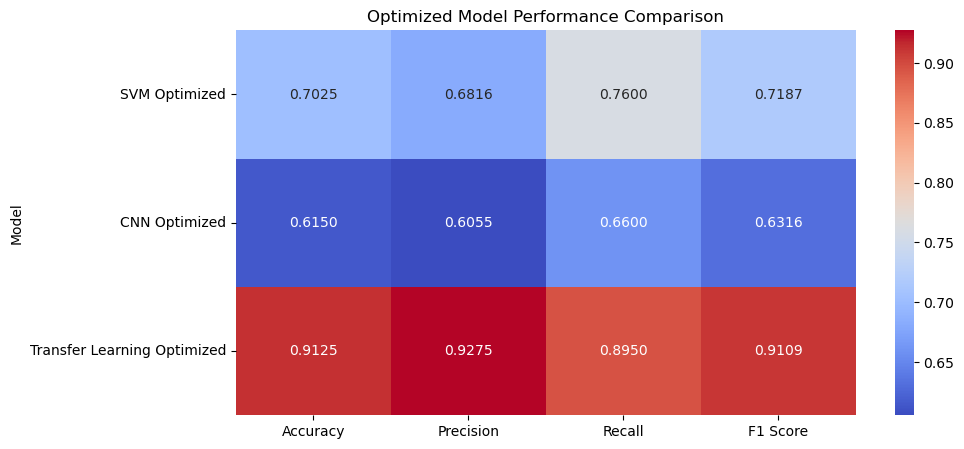

In [177]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate performance metrics for a classification model.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# ---------------------
# Optimized SVM Metrics
# ---------------------
# Ensure `y_pred` is the prediction from the optimized SVM
svm_y_pred = svm_model.predict(X_test_scaled)  # Optimized SVM Predictions
svm_optimized_metrics = calculate_metrics(y_test, svm_y_pred)

# ---------------------
# Optimized CNN Metrics
# ---------------------
cnn_y_pred_optimized = cnn_model_optimized.predict(X_test_cnn)  # Optimized CNN Predictions
cnn_y_pred_optimized_labels = cnn_y_pred_optimized.argmax(axis=1)

# Ensure `y_test_cnn` is in label format
cnn_y_true_labels = y_test_cnn.argmax(axis=1)

cnn_optimized_metrics = calculate_metrics(cnn_y_true_labels, cnn_y_pred_optimized_labels)

# ---------------------
# Optimized Transfer Learning Metrics
# ---------------------
tl_y_pred_optimized = optimized_tl_model.predict(X_test_tl)  # Optimized Transfer Learning Predictions
tl_y_pred_optimized_labels = tl_y_pred_optimized.argmax(axis=1)

# Ensure `y_test_tl` is in label format
tl_y_true_labels = y_test_tl.argmax(axis=1)

tl_optimized_metrics = calculate_metrics(tl_y_true_labels, tl_y_pred_optimized_labels)

# ---------------------
# Compile Results into a DataFrame
# ---------------------
results_df = pd.DataFrame({
    "Model": [
        "SVM Optimized",
        "CNN Optimized",
        "Transfer Learning Optimized"
    ],
    "Accuracy": [
        svm_optimized_metrics[0],
        cnn_optimized_metrics[0],
        tl_optimized_metrics[0]
    ],
    "Precision": [
        svm_optimized_metrics[1],
        cnn_optimized_metrics[1],
        tl_optimized_metrics[1]
    ],
    "Recall": [
        svm_optimized_metrics[2],
        cnn_optimized_metrics[2],
        tl_optimized_metrics[2]
    ],
    "F1 Score": [
        svm_optimized_metrics[3],
        cnn_optimized_metrics[3],
        tl_optimized_metrics[3]
    ]
})

# Style the DataFrame for display
styled_table = results_df.style.set_caption("Optimized Model Performance Comparison") \
                               .set_table_styles(
                                   [{'selector': 'caption', 
                                     'props': [('text-align', 'center'),
                                               ('color', '#2a4d69'),
                                               ('font-size', '16px'),
                                               ('font-weight', 'bold')]}]
                               ) \
                               .background_gradient(cmap='coolwarm', subset=["Accuracy", "Precision", "Recall", "F1 Score"]) \
                               .format(precision=4)

# Display the styled table
display(HTML(styled_table.to_html()))

# ---------------------
# Visualize Results Using a Heatmap
# ---------------------
plt.figure(figsize=(10, 5))
sns.heatmap(results_df.set_index("Model"), annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title("Optimized Model Performance Comparison")
plt.show()



**Analysis**

Based on metric comparison,the transfer learning model is the superior choice for real-life face mask detection. By leveraging pre-trained knowledge from MobileNetV2, it effectively extracts complex, high-level features essential for handling diverse and challenging scenarios. In contrast to SVM and CNN, which rely on simpler or handcrafted features, TL demonstrates exceptional generalization and adaptability. Its fine-tuning capabilities further enhance robustness, making it highly reliable for real-world applications that demand both accuracy and precision.

<a id="Conclude"></a>
⬆️ [Tabel of Contents](#contents_label)
<div style="border-radius:10px; padding: 15px; background-color: #94e3d8; font-size:115%; text-align:left">
<h3 align="left"><font color=#3f0544>8.Conclusion</font></h3> 

Masked face detection is a challenging yet critical task, addressing issues of occlusion, data diversity, and real-time processing. By leveraging robust feature extraction techniques such as HOG, facial landmark ratios, and shape-based features, the models demonstrated an enhanced ability to generalize across diverse scenarios. Data analysis and visualization ensured balanced datasets, improved intensity distributions, and meaningful geometric descriptors, further optimizing model performance.

Among the models evaluated—SVM, CNN, and Transfer Learning—Transfer Learning emerged as the superior approach. Leveraging MobileNetV2 and fine-tuning specific layers, it achieved the highest accuracy and adaptability. Its ability to handle occlusion patterns and diverse mask designs while maintaining efficiency makes it ideal for real-world applications in security, health monitoring, and access control. This project underscores the potential of transfer learning to address real-world challenges, setting a benchmark for future advancements in face mask detection systems.
